In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import rpy2 as rp
import rpy2.robjects as ro
import pyreadr
import os
import time
import h5py
# import mmdet
import scanpy
# import ssam
import pickle
import random
# import pyarrow
import dgl
import ast

from tqdm import tqdm

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score, matthews_corrcoef, mean_squared_error

# from captum.attr import IntegratedGradients
# from captum.attr import LayerConductance
# from captum.attr import NeuronConductance

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

# import torch_geometric

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils

from skimage import io
from skimage import img_as_float
from scipy import ndimage

# from ssam.utils import corr, calc_ctmap, calc_corrmap, flood_fill, calc_kde
from scipy.spatial.distance import cdist

from collections import OrderedDict

from packaging import version
import subprocess

In [3]:
# for i in range(len(df_res)):
# change variable name to fit data being processed

def to_image(df_active, coord_act, dataset_folder, save=False):
    img_dict = {}
    zero_list = []
    
    for i in tqdm(range(len(df_active))):
        gene_id = df_active.loc[i,'gene_id']
        if(df_active.loc[i,'coord_count']<=1):
            zero_list.append(gene_id)
            x_resolution = 200
            y_resolution = 250
            img = np.zeros((y_resolution+20, x_resolution+20), dtype=bool)
            img[:, :] = 0
            img_dict[gene_id] = img
            if(save):
                os.makedirs(dataset_folder ,exist_ok=True)
                np.save(dataset_folder + '/' + gene_id + '.npy',img)
            continue
    
        # get coord_list from dataframe as string back to list
        my_list = ast.literal_eval(df_active.loc[i,'coord_list'])
    
        # table for converting coordinate list into actual pixel coordinates
        ext_coord = coord_act.loc[my_list]
    
        # points = coord673.values.tolist()
        # sites = coord673.index.tolist()
        points = ext_coord.values.tolist()
        sites = ext_coord.index.tolist()
        
        x, y = zip(*points)
        
        # Convert into 2D matrix
        x_resolution = 200
        y_resolution = 250
    
        x_min = min(x)
        x_max = max(x)
        x_ptp = x_max - x_min
    
        y_min = min(y)
        y_max = max(y)
        y_ptp = y_max - y_min
    
        img = np.zeros((y_resolution+20, x_resolution+20), dtype=bool)
    
        # Fit the coordinates into the new resolution
        for k, l in points:
            if x_ptp == 0:
                # print('x:: max: {} min: {}'.format(x_max, x_min))
                # print(points)
                x_pxl = x_resolution/2
            else:
                x_pxl = (k - x_min) / x_ptp * x_resolution
            if y_ptp == 0:
                # print('y:: max: {} min: {}'.format(y_max, y_min))
                # print(points)
                y_pxl = y_resolution/2
            else:
                y_pxl = (l - y_min) / y_ptp * y_resolution
            img[int(y_pxl+10), int(x_pxl+10)] = 1
        
        img_dict[gene_id] = img
        if(save):
            os.makedirs(dataset_folder ,exist_ok=True)
            np.save(dataset_folder + '/' +gene_id + '.npy',img)
            
    return img_dict, zero_list

<h1>Input folder and file names</h1>

In [4]:
data_folder = '/workspace/volume/spatial_integration/GNN_based/combined/processed_data/'
file_names = ['151507','151672', '151673']
save_images = False

<h1>process start</h1>

In [5]:
data_dict = {}
coord_dict = {}
list_dict = {}

# read from rds
for i, file_name in enumerate(file_names, start=1):
    variable_name = f"data_{file_name}"
    df_read = pyreadr.read_r(data_folder+ '/' + f"df_logcount_{file_name}.rds")
    data_dict[variable_name] = df_read[None]

# concatenate all samples read
combined_all = pd.concat(data_dict.values(), axis=1, ignore_index=False)

In [6]:
# template dataframe for coordinate list
df_unfil = pd.DataFrame(combined_all.index.tolist())
df_unfil.columns=["gene_id"]
df_unfil['coord_list'] = pd.Series(dtype=str)
df_unfil['coord_count'] = pd.Series(dtype=int)

In [7]:
for i, file_name in enumerate(file_names, start=1):
    print(f'processing {file_name}:')
    var_data = f'data_{file_name}'
    var_coord = f"coord_{file_name}"
    
    coord_val = pyreadr.read_r(data_folder + f'/coord_{file_name}.rds')
    coord_dict[var_coord] = coord_val[None]

    df_coord = df_unfil.copy()
    list_dict[var_coord] = df_coord
    for i in tqdm(range(len(combined_all))):
        a = data_dict[var_data].iloc[i]
        list_dict[var_coord].loc[i, 'coord_list'] = str(a[a>0].index.tolist())
        list_dict[var_coord].loc[i, 'coord_count'] = len(a[a>0].index.tolist())

processing 507:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 33538/33538 [00:12<00:00, 2728.41it/s]


processing 672:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 33538/33538 [00:12<00:00, 2721.10it/s]


processing 673:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 33538/33538 [00:12<00:00, 2705.10it/s]


<h2>Coordinate list into plotted image</h2>

In [8]:
image = {}
zeros = {}

for i, var_list in enumerate(list_dict.keys()):
    folder_name = file_names[i]
    folder_sample = os.getcwd() + f'/{folder_name}'
    print(folder_sample)
    df_active = list_dict[var_list]
    coord_act = coord_dict[var_list]
    
    image[folder_name], zeros[folder_name] = to_image(df_active, coord_act, folder_sample, save=save_images)

/workspace/volume/spatial_integration/GNN_based/combined/New/Reworked_flow/151507


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 33538/33538 [00:16<00:00, 2054.23it/s]


/workspace/volume/spatial_integration/GNN_based/combined/New/Reworked_flow/151672


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 33538/33538 [00:19<00:00, 1757.41it/s]


/workspace/volume/spatial_integration/GNN_based/combined/New/Reworked_flow/151673


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 33538/33538 [00:21<00:00, 1591.06it/s]


<h3>confirm output with visualization</h3>

ENSG00000116251


<Figure size 800x1000 with 0 Axes>

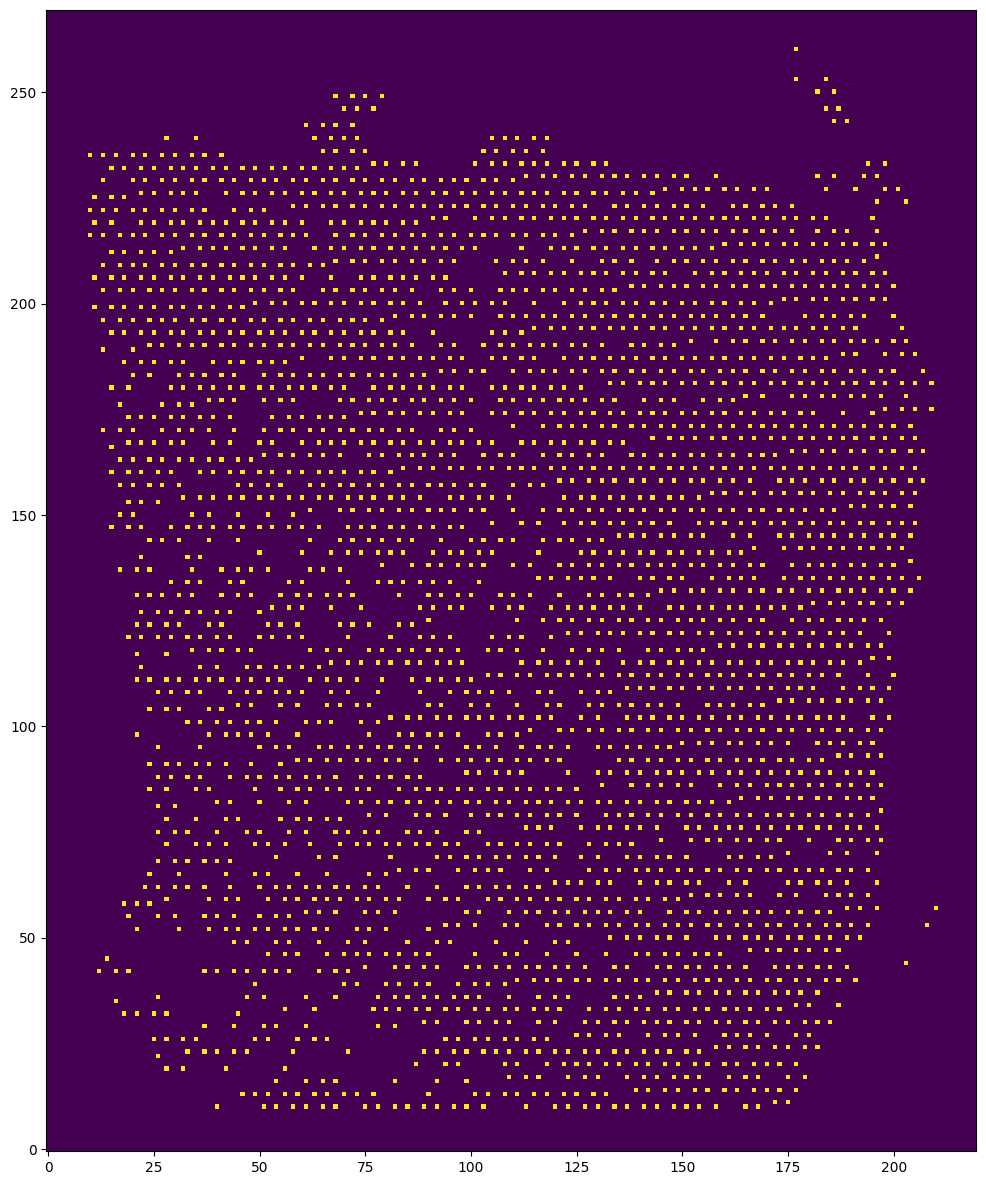

In [23]:
sample = '151673'
for key in image[sample].keys():
    if image[sample][key].sum() > 3000:
        print(key)
        plt.figure(figsize=(8,10))
        
        fig, ax = plt.subplots(1,1,figsize=(12,36))
        
        ax.imshow(image[sample][key], cmap='viridis',origin='lower')
        
        plt.show()
        break

ENSG00000116251.npy


<Figure size 800x1000 with 0 Axes>

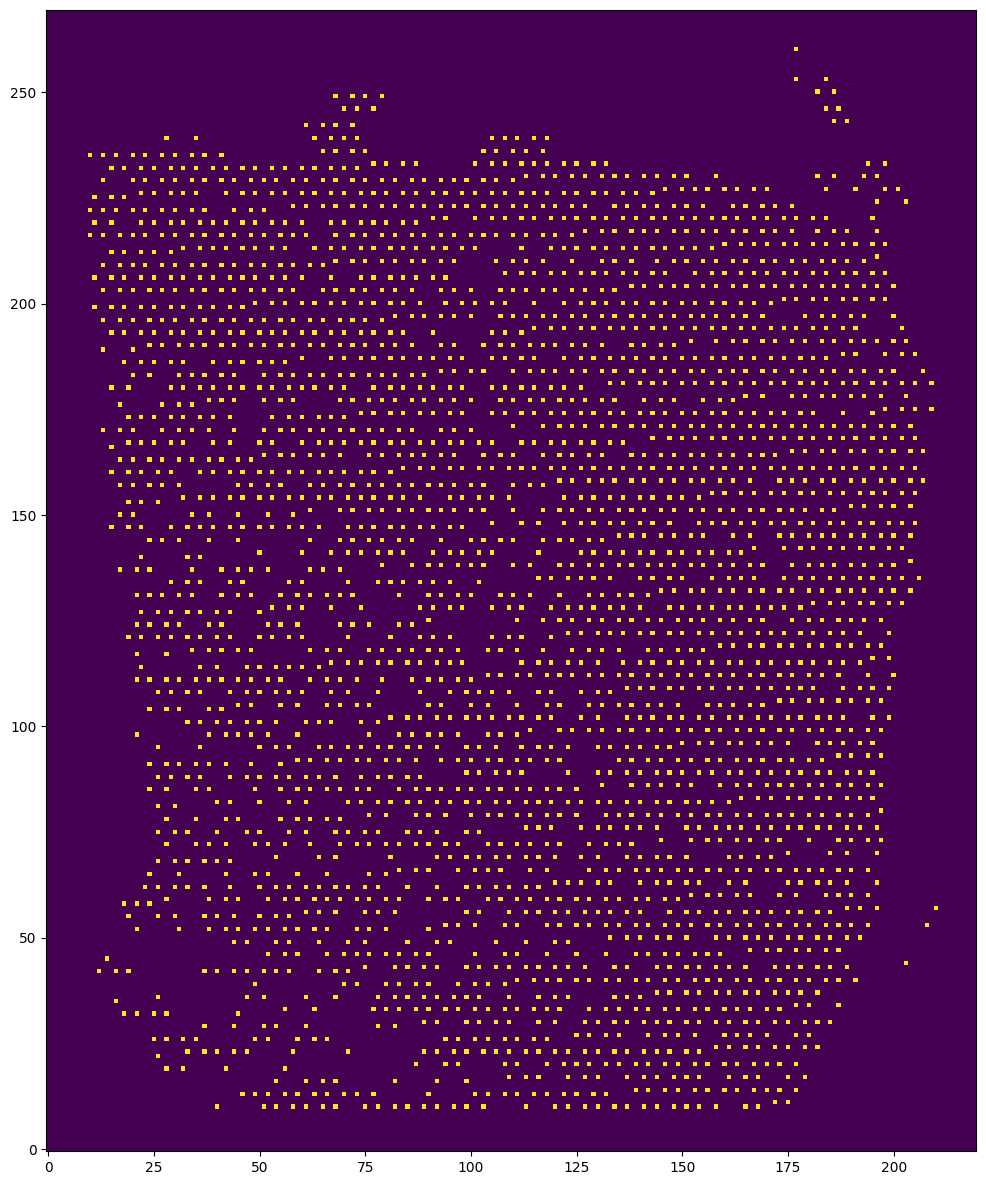

In [25]:
directory = os.getcwd() + '/151673'
filenames = os.listdir(directory)

# plt.figure(figsize=(8,10))

# fig, ax = plt.subplots(3,1,figsize=(12,36))

for i, filename in enumerate(filenames) :
    if filename.endswith('.npy') and os.path.isfile(os.path.join(directory, filename)):
        new_test = np.load(directory+'/'+filename)   
        # ax[i].imshow(new_test, cmap='viridis',origin='lower')
        if new_test.sum() > 3000:
            print(filename)
            plt.figure(figsize=(8,10))
            
            fig, ax = plt.subplots(1,1,figsize=(12,36))
            
            ax.imshow(new_test, cmap='viridis',origin='lower')
        
            plt.show()
            break

<h1>END</h1>

-----------------------